# Project 1: Food Safety 
## Cleaning and Exploring Data with Pandas


## This Assignment
<img src="scoreCard.jpg" width=400>

In this project, you will investigate restaurant food safety scores for restaurants in San Francisco. Above is a sample score card for a restaurant. The scores and violation information have been made available by the San Francisco Department of Public Health. The main goal for this assignment is to understand how restaurants are scored. We will walk through various steps of exploratory data analysis to do this. We will provide comments and insights along the way to give you a sense of how we arrive at each discovery and what next steps it leads to.

As we clean and explore these data, you will gain practice with:
* Reading simple csv files
* Working with data at different levels of granularity
* Identifying the type of data collected, missing values, anomalies, etc.
* Applying probability sampling techniques
* Exploring characteristics and distributions of individual variables

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import zipfile

sns.set()

In [3]:
import sys

assert 'zipfile'in sys.modules
assert 'pandas'in sys.modules and pd
assert 'numpy'in sys.modules and np
assert 'matplotlib'in sys.modules and plt

## Downloading the Data

For this assignment, we need this data file: http://www.ds100.org/sp19/assets/datasets/proj1-SFBusinesses.zip

We could write a few lines of code that are built to download this specific data file, but it's a better idea to have a general function that we can reuse for all of our assignments. Since this class isn't really about the nuances of the Python file system libraries, we've provided a function for you in ds100_utils.py called `fetch_and_cache` that can download files from the internet.

This function has the following arguments:
- data_url: the web address to download
- file: the file in which to save the results
- data_dir: (default="data") the location to save the data
- force: if true the file is always re-downloaded 

The way this function works is that it checks to see if `data_dir/file` already exists. If it does not exist already or if `force=True`, the file at `data_url` is downloaded and placed at `data_dir/file`. The process of storing a data file for reuse later is called caching. If `data_dir/file` already and exists `force=False`, nothing is downloaded, and instead a message is printed letting you know the date of the cached file.

The function returns a `pathlib.Path` object representing the location of the file ([pathlib docs](https://docs.python.org/3/library/pathlib.html#basic-use)). 

In [4]:
import ds100_utils
source_data_url = 'http://www.ds100.org/sp19/assets/datasets/proj1-SFBusinesses.zip'
target_file_name = 'data.zip'

# Change the force=False -> force=True in case you need to force redownload the data
dest_path = ds100_utils.fetch_and_cache(
    data_url=source_data_url, 
    data_dir='.', 
    file=target_file_name, 
    force=False)

Using cached version that was downloaded (UTC): Fri Jun 28 23:54:56 2019


After running the cell above, if you list the contents of the directory containing this notebook, you should see `data.zip`.

In [5]:
# !ls

## 1: Loading Food Safety Data

We have data, but we don't have any specific questions about the data yet, so let's focus on understanding the structure of the data. This involves answering questions such as:

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

Let's start by looking at the contents of `data.zip`. It's not just a single file, but a compressed directory of multiple files. We could inspect it by uncompressing it using a shell command such as `!unzip data.zip`, but in this project we're going to do almost everything in Python for maximum portability.

### Question 1a: Looking Inside and Extracting the Zip Files

Assign `my_zip` to a `Zipfile.zipfile` object representing `data.zip`, and assign `list_files` to a list of all the names of the files in `data.zip`.

*Hint*: The [Python docs](https://docs.python.org/3/library/zipfile.html) describe how to create a `zipfile.ZipFile` object. You might also look back at the code from lecture and lab. It's OK to copy and paste code from previous assignments and demos, though you might get more out of this exercise if you type out an answer.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
my_zip = zipfile.ZipFile(dest_path)
list_names = my_zip.namelist()
list_names

['violations.csv', 'businesses.csv', 'inspections.csv', 'legend.csv']

In your answer above, if you have written something like `zipfile.ZipFile('data.zip', ...)`, we suggest changing it to read `zipfile.ZipFile(dest_path, ...)`. In general, we **strongly suggest having your filenames hard coded as string literals only once** in a notebook. It is very dangerous to hard code things twice, because if you change one but forget to change the other, you can end up with bugs that are very hard to find.

Now display the files' names and their sizes.

If you're not sure how to proceed, read about the attributes of a `ZipFile` object in the Python docs linked above.

In [7]:
for zinfo in my_zip.filelist:
    print (zinfo)

<ZipInfo filename='violations.csv' compress_type=deflate external_attr=0x20 file_size=3726206 compress_size=286253>
<ZipInfo filename='businesses.csv' compress_type=deflate external_attr=0x20 file_size=660231 compress_size=178549>
<ZipInfo filename='inspections.csv' compress_type=deflate external_attr=0x20 file_size=466106 compress_size=83198>
<ZipInfo filename='legend.csv' compress_type=deflate external_attr=0x20 file_size=120 compress_size=104>


Often when working with zipped data, we'll never unzip the actual zipfile. This saves space on our local computer. However, for this project, the files are small, so we're just going to unzip everything. This has the added benefit that you can look inside the csv files using a text editor, which might be handy for understanding what's going on. The cell below will unzip the csv files into a subdirectory called `data`. Just run it.

In [8]:
from pathlib import Path
data_dir = Path('data')
my_zip.extractall(data_dir)
# !ls {data_dir}

The cell above created a folder called `data`, and in it there should be four CSV files. Open up `legend.csv` to see its contents. Click on 'Jupyter' in the top left, then navigate to su19/proj/proj1/data/ and click on `legend.csv`. The file will open up in another tab. You should see something that looks like:

    "Minimum_Score","Maximum_Score","Description"
    0,70,"Poor"
    71,85,"Needs Improvement"
    86,90,"Adequate"
    91,100,"Good"

### Question 1b: Programatically Looking Inside the Files

The `legend.csv` file does indeed look like a well-formed CSV file. Let's check the other three files. Rather than opening up each file manually, let's use Python to print out the first 5 lines of each. The `ds100_utils` library has a method called `head` that will allow you to retrieve the first N lines of a file as a list. For example `ds100_utils.head('data/legend.csv', 5)` will return the first 5 lines of "data/legend.csv". Try using this function to print out the first 5 lines of all four files that we just extracted from the zipfile.

In [9]:
ds100_utils.head('data/legend.csv', 5)

['"Minimum_Score","Maximum_Score","Description"\n',
 '0,70,"Poor"\n',
 '71,85,"Needs Improvement"\n',
 '86,90,"Adequate"\n',
 '91,100,"Good"\n']

### Question 1c: Reading in the Files

Based on the above information, let's attempt to load `businesses.csv`, `inspections.csv`, and `violations.csv` into pandas data frames with the following names: `bus`, `ins`, and `vio` respectively.

*Note:* Because of character encoding issues one of the files (`bus`) will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. One day you should read all about [character encodings](https://www.diveinto.org/python3/strings.html).

In [10]:
# path to directory containing data
dsDir = Path('data')

bus = pd.read_csv('data/businesses.csv',encoding='ISO-8859-1')
ins = pd.read_csv('data/inspections.csv',encoding='ISO-8859-1')
vio = pd.read_csv('data/violations.csv',encoding='ISO-8859-1')

Now that you've read in the files, let's try some `pd.DataFrame` methods ([docs](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html)).
Use the `DataFrame.head` method to show the top few lines of the `bus`, `ins`, and `vio` dataframes. To show multiple return outputs in one single cell, you can use `display()`. Use `Dataframe.describe` to learn about the numeric columns.

In [11]:
from IPython.display import display
display(bus.head())
display(ins.head())
display(vio.head())

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


,business_id,date,description
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


The `DataFrame.describe` method can also be handy for computing summaries of various statistics of our dataframes. Try it out with each of our 3 dataframes.

In [12]:
display(bus.describe())
display(ins.describe())
display(vio.describe())

,business_id,latitude,longitude
count,6406.000000,3270.000000,3270.000000
mean,53058.248049,37.773662,-122.425791
std,34928.238762,0.022910,0.027762
min,19.000000,37.668824,-122.510896
25%,7405.500000,37.760487,-122.436844
50%,68294.500000,37.780435,-122.418855
75%,83446.500000,37.789951,-122.406609
max,94574.000000,37.824494,-122.368257


,business_id,score,date
count,14222.000000,14222.000000,1.422200e+04
mean,45138.752637,90.697370,2.016242e+07
std,34497.913056,8.088705,8.082778e+03
min,19.000000,48.000000,2.015013e+07
25%,5634.000000,86.000000,2.016021e+07
50%,61462.000000,92.000000,2.016091e+07
75%,78074.000000,96.000000,2.017061e+07
max,94231.000000,100.000000,2.018012e+07


,business_id,date
count,39042.000000,3.904200e+04
mean,45674.440244,2.016283e+07
std,34172.433276,7.874679e+03
min,19.000000,2.015013e+07
25%,4959.000000,2.016031e+07
50%,62060.000000,2.016092e+07
75%,77681.000000,2.017063e+07
max,94231.000000,2.018012e+07


Now, we perform some sanity checks for you to verify that you loaded the data with the right structure. Run the following cells to load some basic utilities (you do not need to change these at all):

First, we check the basic structure of the data frames you created:

In [13]:
assert all(bus.columns == ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
                           'latitude', 'longitude', 'phone_number'])
assert 6400 <= len(bus) <= 6420

assert all(ins.columns == ['business_id', 'score', 'date', 'type'])
assert 14210 <= len(ins) <= 14250

assert all(vio.columns == ['business_id', 'date', 'description'])
assert 39020 <= len(vio) <= 39080

Next we'll check that the statistics match what we expect. The following are hard-coded statistical summaries of the correct data.

In [14]:
bus_summary = pd.DataFrame(**{'columns': ['business_id', 'latitude', 'longitude'],
 'data': {'business_id': {'50%': 68294.5, 'max': 94574.0, 'min': 19.0},
  'latitude': {'50%': 37.780435, 'max': 37.824494, 'min': 37.668824},
  'longitude': {'50%': -122.41885450000001,
   'max': -122.368257,
   'min': -122.510896}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['business_id', 'score'],
 'data': {'business_id': {'50%': 61462.0, 'max': 94231.0, 'min': 19.0},
  'score': {'50%': 92.0, 'max': 100.0, 'min': 48.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['business_id'],
 'data': {'business_id': {'50%': 62060.0, 'max': 94231.0, 'min': 19.0}},
 'index': ['min', '50%', 'max']})

from IPython.display import display

print('What we expect from your Businesses dataframe:')
display(bus_summary)
print('What we expect from your Inspections dataframe:')
display(ins_summary)
print('What we expect from your Violations dataframe:')
display(vio_summary)

What we expect from your Businesses dataframe:


,business_id,latitude,longitude
min,19.0,37.668824,-122.510896
50%,68294.5,37.780435,-122.418855
max,94574.0,37.824494,-122.368257


What we expect from your Inspections dataframe:


,business_id,score
min,19.0,48.0
50%,61462.0,92.0
max,94231.0,100.0


What we expect from your Violations dataframe:


,business_id
min,19.0
50%,62060.0
max,94231.0


The code below defines a testing function that we'll use to verify that your data has the same statistics as what we expect. Run these cells to define the function. The `df_allclose` function has this name because we are verifying that all of the statistics for your dataframe are close to the expected values. Why not `df_allequal`? It's a bad idea in almost all cases to compare two floating point values like 37.780435, as rounding error can cause spurious failures.

## Question 1d: Verifying the data

Now let's run the automated tests. If your dataframes are correct, then the following cell will seem to do nothing, which is a good thing! However, if your variables don't match the correct answers in the main summary statistics shown above, an exception will be raised.

<!--
BEGIN QUESTION
name: q1d
points: 3
-->

In [15]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""


def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.
    
    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.
    
    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """    
    # summary statistics to compare on
    stats = ['min', '50%', 'max']
    
    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case, 
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    return np.allclose(act, des, rtol)

### Question 1e: Identifying Issues with the Data

Use the `head` command on your three files again. This time, describe at least one potential problem with the data you see. Consider issues with missing values and bad data.

<!--
BEGIN QUESTION
name: q1e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

- besiness_id is not index of data frame, so three table cannot be joined or merged.
- 'city' and 'state' in 'bus' are redundant because all the values are the same.
- there are NaNs or named missing values.
- 'date' in 'ins' and 'vio' is not in datetime format.
- 'description' in 'vio' is hard to generate information.

We will explore each file in turn, including determining its granularity and primary keys and exploring many of the variables individually. Let's begin with the businesses file, which has been read into the `bus` dataframe.

---
## 2: Examining the Business Data

From its name alone, we expect the `businesses.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

**Important note: From now on, the local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Question 2a

Examining the entries in `bus`, is the `business_id` unique for each record that is each row of data? Your code should compute the answer, i.e. don't just hard code `True` or `False`.

Hint: use `value_counts()` or `unique()` to determine if the `business_id` series has any duplicates.

<!--
BEGIN QUESTION
name: q2a
points: 1
-->

In [16]:
is_business_id_unique = len(bus['business_id'].unique()) == bus.shape[0]

### Question 2b

With this information, you can address the question of granularity. Answer the questions below.

1. What does each record represent (e.g., a business, a restaurant, a location, etc.)?  
1. What is the primary key?
1. What would you find by grouping by the following columns: `business_id`, `name`, `address` each individually?

Please write your answer in the markdown cell below. You may create new cells below your answer to run code, but **please never add cells between a question cell and the answer cell below it.**

1. Each record represents a restaurant
1. The primary key is business_id
1. The number of records is not changed when grouping by 'business_id' because all the values of 'business_id' are unique and 'business_id' is primary key. As for grouping by 'name' and 'address', the number of records is reduced because some restaurants have same name and some are in the same location.


In [17]:
display(bus[:1])
display(bus['name'].size == bus.shape[0])
display(bus.groupby(bus['business_id']).first())
display(bus.groupby(bus['name']).first())
display(bus.groupby(bus['address']).first())

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262


True

,name,address,city,state,postal_code,latitude,longitude,phone_number
business_id,,,,,,,,
19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440
...,...,...,...,...,...,...,...,...
94544,D'MAIZE CAFE,50 PHELAN AVE,San Francisco,CA,94112,NaN,NaN,+14154240604
94555,EASY BREEZY FROZEN YOGURT,44 WEST PORTAL AVE,San Francisco,CA,94127,NaN,NaN,+14155053351
94571,THE PHOENIX PASTIFICIO,200 CLEMENT ST,San Francisco,CA,94118,NaN,NaN,+14154726100


,business_id,address,city,state,postal_code,latitude,longitude,phone_number
name,,,,,,,,
MAGNOLIA BREWING COMPANY,93539,1398 HAIGHT ST,San Francisco,CA,94117,NaN,NaN,+14153700349
NORDSTROM CAFE BISTRO,1674,865 MARKET ST,San Francisco,CA,94103,37.784317,-122.407563,+14159775154
100% DESSERT CAFE,37633,2512 CLEMENT ST,San Francisco,CA,94121,37.781988,-122.486252,+14153097778
111 MINNA GALLERY,65776,111 MINNA ST,San Francisco,CA,94105,37.787378,-122.399459,+14159741719
12 TRIBES KOSHER FOODS,68597,3200 CALIFORNIA ST,San Francisco,CA,94118,37.787311,-122.446839,+14158008594
...,...,...,...,...,...,...,...,...
ZUNI CAFE,3645,1658 MARKET ST,San Francisco,CA,94102,37.773415,-122.421598,+14155522522
ZUSHI-PUZZLE,2063,1910 LOMBARD ST,San Francisco,CA,94123,37.800248,-122.433053,+14159319319
ZUTUHIL AZTECA,92318,601 MISSION BAY BLVD,San Francisco,CA,94158,NaN,NaN,+14157178125


,business_id,name,city,state,postal_code,latitude,longitude,phone_number
address,,,,,,,,
,77922,ASDLJDLST G FDH,San Francisco,CA,NaN,NaN,NaN,NaN
16TH AND SHOTWELL ST,62277,TACOS SAN BUENA,San Francisco,CA,94102,37.779847,-122.418985,+14155596127
1700 O'FARRELL @ FILLMORE ST,33998,COASTSIDE FARMS AND SPECIALTIES,San Francisco,CA,94115,NaN,NaN,+14156606560
377,7477,HARBOR EMPEROR,San Francisco,CA,94133,37.808494,-122.412000,+14158723124
APPROVED LOCATIONS,85316,CURRY UP NOW,San Francisco,CA,NaN,NaN,NaN,+14158237000
...,...,...,...,...,...,...,...,...
PIER 9,5312,THE WATERFRONT,San Francisco,CA,94111,NaN,NaN,+14153987541
STOCKTON & MARKET & ELLIS ST (NW),5441,ANNIE'S HOT DOGS,San Francisco,CA,94102,37.779847,-122.418985,+14158610778
TREASURE ISLAND 888 AVENUE H,63091,MAYA WATERS,San Francisco,CA,94130,NaN,NaN,+14156137162


---
## 3: Zip Codes

Next, let's  explore some of the variables in the business table. We begin by examining the postal code.

### Question 3a

Answer the following questions about the `postal code` column in the `bus` data frame?  
1. Are ZIP codes quantitative or qualitative? If qualitative, is it ordinal or nominal? 
1. What data type is used to represent a ZIP code?

*Note*: ZIP codes and postal codes are the same thing.


1. ZIP codes are qualitative and nominal.
1. string

### Question 3b

How many restaurants are in each ZIP code? 

In the cell below, create a series where the index is the postal code and the value is the number of records with that postal code in descending order of count. 94110 should be at the top with a count of 596. You may want to use `.size()` or `.value_counts()`. 

In [18]:
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


In [19]:
zip_counts = bus['postal_code'].value_counts()
zip_counts.head()

94110    596
94103    552
94102    462
94107    460
94133    426
Name: postal_code, dtype: int64

Did you take into account that some businesses have missing ZIP codes?

In [20]:
print('zip_counts describes', sum(zip_counts), 'records.')
print('The original data have', len(bus), 'records')

zip_counts describes 6166 records.
The original data have 6406 records


Missing data is extremely common in real-world data science projects. There are several ways to include missing postal codes in the `zip_counts` series above. One approach is to use the `fillna` method of the series, which will replace all null (a.k.a. NaN) values with a string of our choosing. In the example below, we picked "?????". When you run the code below, you should see that there are 240 businesses with missing zip code.

In [21]:
zip_counts = bus.fillna("?????").groupby("postal_code").size().sort_values(ascending=False)
zip_counts.head(15)

postal_code
94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
?????    240
94105    232
94108    228
94114    223
94117    204
dtype: int64

An alternate approach is to use the DataFrame `value_counts` method with the optional argument `dropna=False`, which will ensure that null values are counted. In this case, the index will be `NaN` for the row corresponding to a null postal code.

In [22]:
bus["postal_code"].value_counts(dropna=False).sort_values(ascending = False).head(15)

94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
NaN      240
94105    232
94108    228
94114    223
94117    204
Name: postal_code, dtype: int64

Missing zip codes aren't our only problem. There are also some records where the postal code is wrong, e.g., there are 3 'Ca' and 3 'CA' values. Additionally, there are some extended postal codes that are 9 digits long, rather than the typical 5 digits. We will dive deeper into problems with postal code entries in subsequent questions. 

For now, let's clean up the extended zip codes by dropping the digits beyond the first 5. Rather than deleting or replacing the old values in the `postal_code` columnm, we'll instead create a new column called `postal_code_5`.

The reason we're making a new column is that it's typically good practice to keep the original values when we are manipulating data. This makes it easier to recover from mistakes, and also makes it more clear that we are not working with the original raw data.

In [23]:
bus['postal_code_5'] = bus['postal_code'].str[:5]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


### Question 3c : A Closer Look at Missing ZIP Codes

Let's look more closely at records with missing ZIP codes. Describe why some records have missing postal codes.  Pay attention to their addresses. You will need to look at many entries, not just the first five.

*Hint*: The `isnull` method of a series returns a boolean series which is true only for entries in the original series that were missing.

<!--
BEGIN QUESTION
name: q3c
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

In 'address', some are off the grid, some are private lovations, some are various locations, so they don't have postal codes. Maybe other's addresses are not clear so they also don't have postal codes.

In [24]:
nanframe = bus[bus['postal_code'].isnull()]
nanframe.head()
# nanframe['address'].head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
1702,8202,XIAO LOONG,250 WEST PORTAL AVENUE,San Francisco,CA,NaN,37.738616,-122.468775,+14152792647,NaN
1725,9358,EDGEWOOD CHILDREN'S CENTER,1801 VICENTE ST,San Francisco,CA,NaN,37.739083,-122.485437,NaN,NaN
1731,9582,DIMPLES,1700 POST ST.,San Francisco,CA,NaN,37.785632,-122.429794,+14155190341,NaN
1747,10011,OSHA THAI NOODLE,819 VALENCIA ST.,San Francisco,CA,NaN,37.759943,-122.421332,+14153109293,NaN
1754,10227,THE NAPPER TANDY,3200 24TH ST,San Francisco,CA,NaN,37.752581,-122.416482,+14155507510,NaN


### Question 3d: Incorrect ZIP Codes

This dataset is supposed to be only about San Francisco, so let's set up a list of all San Francisco ZIP codes.

In [25]:
all_sf_zip_codes = ["94102", "94103", "94104", "94105", "94107", "94108", 
                    "94109", "94110", "94111", "94112", "94114", "94115", 
                    "94116", "94117", "94118", "94119", "94120", "94121", 
                    "94122", "94123", "94124", "94125", "94126", "94127", 
                    "94128", "94129", "94130", "94131", "94132", "94133", 
                    "94134", "94137", "94139", "94140", "94141", "94142", 
                    "94143", "94144", "94145", "94146", "94147", "94151", 
                    "94158", "94159", "94160", "94161", "94163", "94164", 
                    "94172", "94177", "94188"]

Set `weird_zip_code_businesses` equal to a new dataframe showing only rows corresponding to ZIP codes that are not valid - either not 5-digit long or not a San Francisco zip code - and not missing. Use the `postal_code_5` column.

*Hint*: The `~` operator inverts a boolean array. Use in conjunction with `isin`.

<!--
BEGIN QUESTION
name: q3d1
points: 0
-->

In [26]:
weird_zip_code_businesses = bus[(~bus['postal_code_5'].isnull()) & (~bus['postal_code_5'].isin(all_sf_zip_codes)) ]
weird_zip_code_businesses

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
1211,5208,GOLDEN GATE YACHT CLUB,1 YACHT RD,San Francisco,CA,941,37.807878,-122.442499,+14153462628,941
1372,5755,J & J VENDING,VARIOUS LOACATIONS (17),San Francisco,CA,94545,NaN,NaN,+14156750910,94545
1373,5757,"RICO VENDING, INC",VARIOUS LOCATIONS,San Francisco,CA,94066,NaN,NaN,+14155836723,94066
2258,36547,EPIC ROASTHOUSE,PIER 26 EMBARARCADERO,San Francisco,CA,95105,37.788962,-122.387941,+14153699955,95105
2293,37167,INTERCONTINENTAL SAN FRANCISCO EMPLOYEE CAFETERIA,888 HOWARD ST 2ND FLOOR,San Francisco,CA,94013,37.781664,-122.404778,+14156166532,94013
2295,37169,INTERCONTINENTAL SAN FRANCISCO 4TH FL. KITCHEN,888 HOWARD ST 4TH FLOOR,San Francisco,CA,94013,37.781664,-122.404778,+14156166532,94013
2846,64540,LEO'S HOT DOGS,2301 MISSION ST,San Francisco,CA,CA,37.760054,-122.419166,+14152406434,CA
2852,64660,HAIGHT STREET MARKET,1530 HAIGHT ST,San Francisco,CA,92672,37.769957,-122.447533,+14152550643,92672
2857,64738,JAPACURRY,PUBLIC,San Francisco,CA,CA,37.777122,-122.419639,+14152444785,CA
2969,65856,BAMBOO ASIA,41 MONTGOMERY ST,San Francisco,CA,94101,37.774998,-122.418299,+14156246790,94101


If we were doing very serious data analysis, we might indivdually look up every one of these strange records. Let's focus on just two of them: ZIP codes 94545 and 94602. Use a search engine to identify what cities these ZIP codes appear in. Try to explain why you think these two ZIP codes appear in your dataframe. For the one with ZIP code 94602, try searching for the business name and locate its real address.
<!--
BEGIN QUESTION
name: q3d2
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

94545 is in Hayward, California, 94602 is in Oakland, California.

I think maybe those restaurants have moved to San Francisco but not update the zip codes.
orbit room's current location is 1900 Market St, San Francisco, CA 94102

### Question 3e

We often want to clean the data to improve our analysis. This cleaning might include changing values for a variable or dropping records.

The value 94602 is wrong. Change it to the most reasonable correct value, using all information you have available. Modify the `postal_code_5` field using `bus['postal_code_5'].str.replace` to replace 94602.

<!--
BEGIN QUESTION
name: q3e
points: 1
-->

In [27]:
# WARNING: Be careful when uncommenting the line below, it will set the entire column to NaN unless you 
# put something to the right of the ellipses.
bus['postal_code_5'] = bus['postal_code_5'].str.replace('94602','94102')

### Question 3f

Now that we have corrected one of the weird postal codes, let's filter our `bus` data such that only postal codes from San Francisco remain. While we're at it, we'll also remove the businesses that are missing a postal code. As we mentioned in question 3d, filtering our postal codes in this way may not be ideal. (Fortunately, this is just a course assignment.) Use the `postal_code_5` column.

Assign `bus` to a new dataframe that has the same columns but only the rows with ZIP codes in San Francisco.

<!--
BEGIN QUESTION
name: q3f
points: 1
-->

In [28]:
bus = bus[bus['postal_code_5'].isin(all_sf_zip_codes)]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


## 4: Sampling from the Business Data
We can now sample from the business data using the cleaned ZIP code data. Make sure to use `postal_code_5` instead of `postal_code` for all parts of this question.

### Question 4a

First, complete the following function `sample`, which takes an arguments a series, `series`, and a sample size, `n`, and returns a simple random sample (SRS) of size `n` from the series. Recall that in SRS, sampling is performed **without** replacement. 

The result should be a **list** of the `n` values that are in the sample.

*Hint*: Consider using [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.random.choice.html).


In [29]:
def sample(series, n):
    # Do not change the following line of code in any way!
    # In case you delete it, it should be "np.random.seed(40)"
    np.random.seed(40)
    return list(np.random.choice(series,n,replace=False))

### Question 4b
Suppose we take a SRS of 5 businesses from the business data. What is the probability that the business named AMERICANA GRILL & FOUNTAIN is in the sample?
<!--
BEGIN QUESTION
name: q4b
points: 1
-->

In [30]:
q4b_answer = (5*5*4*3*2)/(6146*6145*6144*6143*6142)
q4b_answer

6.853229454811753e-17

### Question 4c

**New content: Stratified Sampling**

In simple random sampling (SRS), every member or set of members has an equal chance to be selected in the final sample. We often use this method when we don’t have any kind of prior information about the target population.

Here, we actually do have a good amount of information about the population - address, coordinates, phone number, and postal code, etc. Let's try to use one of these information in our new sampling, by grouping the members via a specific factor/piece of information. 

Members of the population are first partitioned into groups, called **strata**, by their postal codes. Then, within each group (**stratum**), members are randomly selected into the final probability sample, which is often a simple random sample (SRS). This method is called **stratified sampling**. 

**EXAMPLE:**
In Spring 2019, there were 800 students enrolled in Data 100, each of whom signed up for 1 of the 35 sections. Now we would like to survey 120 students to hear their thoughts on the midterm exam. One of the TAs proposed to do a stratified sampling; he grouped students by their standings - freshman, sophomore, junior, senior, graduate (5 **strata** in total) - and randomly chose 24 students in each group (**stratum**), and survey these 120 students. 

Now let's try to collect a stratified random sample of business names, where each stratum consists of a postal code. Collect one business name per stratum. Assign `bus_strat_sample` to a series of business names selected by this sampling procedure. Your output should be a series with the individual business names (not lists of one element each) as the values.

Hint: You can use the `sample` function you defined earlier. Also consider using `lambda x` when applying a function to a group. 

<!--
BEGIN QUESTION
name: q4c
points: 1
-->

In [31]:
bus_strat_sample = bus['name'].groupby(bus['postal_code_5']).apply(lambda x: sample(x,1)[0]).to_frame()
bus_strat_sample.head()

,name
postal_code_5,
94102,TURK & LARKIN DELI
94103,THE CHENNAI CLUB
94104,PLOUF
94105,JUICE SHOP
94107,BAYSIDE MARKET


### Question 4d

What is the probability that AMERICANA GRILL & FOUNTAIN is selected as part of this stratified random sampling procedure?

In [33]:
q4d_answer = 1/160
q4d_answer

0.00625

### Question 4e

**New content: Cluster Sampling**

Different from stratified sampling, in some cases we may not need a member from each group (stratum). Another way to utilize the information we have about the population is cluster sampling. 

In cluster sampling, the population is also first divided into groups, called **clusters**, based on prior known information. Note that in cluster sampling, every member of the population is assigned to one, and only one, cluster. A sample of clusters is then chosen, using a probability method (often simple random sampling). All members of the selected clusters will be in the final probability sample. 

**EXAMPLE:**
In Spring 2019, there were 800 students enrolled in Data 100, each of whom signed up for 1 of the 35 sections. Another TA proposed to do a cluster sampling; there were 35 sections that each has 25 seats. She randomly selected 5 sections (clusters); she didn't know how many students were there in each of these 5 sections (clusters). She ended up surveying 119 students. 


Now, let's try collect a cluster sample of business IDs, where each cluster is a postal code, with 5 clusters in the sample. Assign `bus_cluster_sample` to a series of business IDs selected by this sampling procedure. Reminder: Use the `postal_code_5` column.

Hint: Consider using [`isin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html).

In [35]:
bus_cluster_sample = bus[bus["postal_code_5"].isin(sample(bus['postal_code_5'].unique(),5))]['business_id']
bus_cluster_sample.head()

2      31
8      61
18     98
25    125
36    190
Name: business_id, dtype: int64

### Question 4f
What is the probability that AMERICANA GRILL & FOUNTAIN is selected as part of this cluster sampling procedure?

In [37]:
q4f_answer = (5*5*4*3*2)/(30*29*28*27*26)
q4f_answer

3.508624198279371e-05

### Question 4g
In the context of this question, what are the benefit(s) you can think of performing SRS over stratified sampling? what about stratified sampling over cluster sampling? Why would you consider performing one sampling method over another? Compare the strengths and weaknesses of these three sampling techniques.

- To do stratified sampling, people need to divide dataset to several subsets with no overlap and it takes time.It can only be used to some of studies that categories are known. While SRS is simple and easy to conduct.
- Stratified sampling reflects population which makes sure points from all subsets are involved. Since clusters chosen by cluster sampling are random, there may be bias in clusters.
- The reason why we need to consider performing one sampling method over another: one is to better understand the advantages and disadvantages of those three sampling method and know which kind of sampling method is better to be used on different datasets. Because one method may suitable for one dataset but not the other.
- **SRS**: strengths:it is easy to carry out. people select samples from population so it is generalized and unbiased; weaknesses: all population are needed. **Stratified sampling**: strengths: it reduces bias. weakness: it is not useful when the data cannot be divided into subsets with no overlap. **Cluster sampling**: strengths:variabiliy can be reduced. weakness: there may be bias.

### Question 4h
Collect a multi-stage sample. First, take a SRS of 5 postal codes. You should have 5 unique postal codes after this. Then, collect an SRS of one business name per selected postal code. Assign `bus_multi_sample` to a series of names selected by this procedure. You may need to sort your result by `postal_code_5` in an ascending order. 

Similar to 4c, try using the individual businesses names as the values of the series instead of lists of one business name each.

In [40]:
np.random.seed(40) # Do not touch this!
selected = bus[bus['postal_code_5'].isin(sample(bus['postal_code_5'].unique(), 5))]
bus_multi_sample = selected['name'].groupby(selected['postal_code_5']).apply(lambda x: sample(x,1)[0]).to_frame()
bus_multi_sample['name']

postal_code_5
94105                   JUICE SHOP
94118    PEABODY ELEMENTARY SCHOOL
94124         THREE BABES BAKESHOP
94133                    WALGREENS
94134               FAT BELLI DELI
Name: name, dtype: object

### Question 4i
What is the probability that AMERICANA GRILL & FOUNTAIN is chosen in the multi-stage sample (from 4h)?


In [42]:
q4i_answer = 1/(160*6)
q4i_answer

0.0010416666666666667

---
## 5: Latitude and Longitude

Let's also consider latitude and longitude values in the `bus` data frame and get a sense of how many are missing.

### Question 5a

How many businesses are missing longitude values?

*Hint*: Use `isnull`.

In [45]:
num_missing_longs = bus[bus['longitude'].isnull()].shape[0]
num_missing_longs

2942

As a somewhat contrived exercise in data manipulation, let's try to identify which ZIP codes are missing the most longitude values.

Throughout problems 5a and 5b, let's focus on only the "dense" ZIP codes of the city of San Francisco, listed below as `sf_dense_zip`.

In [46]:
sf_dense_zip = ["94102", "94103", "94104", "94105", "94107", "94108",
                "94109", "94110", "94111", "94112", "94114", "94115",
                "94116", "94117", "94118", "94121", "94122", "94123", 
                "94124", "94127", "94131", "94132", "94133", "94134"]

In the cell below, create a series where the index is `postal_code_5`, and the value is the number of businesses with missing longitudes in that ZIP code. Your series should be in descending order (the values should be in descending order). The first two rows of your answer should include postal code 94103 and 94110. Only businesses from `sf_dense_zip` should be included. 

*Hint: Start by making a new dataframe called `bus_sf` that only has businesses from `sf_dense_zip`.*

*Hint: Use `len` or `sum` to find out the output number.*

*Hint: Create a custom function to compute the number of null entries in a series, and use this function with the `agg` method.*
<!--
BEGIN QUESTION
name: q5a2
points: 1
-->

In [47]:
def findnull(x):
    return len(x[x.isnull() == True])
bus_sf = bus[bus['postal_code_5'].isin(sf_dense_zip)]

num_missing_in_each_zip = bus_sf['longitude'].groupby(bus_sf['postal_code_5']).agg([findnull]).sort_values('findnull',ascending = False)

### Question 5b

In question 5a, we counted the number of null values per ZIP code. Reminder: we still only use the zip codes found in `sf_dense_zip`. Let's now count the proportion of null values of longitudinal coordinates.

Create a new dataframe of counts of the null and proportion of null values, storing the result in `fraction_missing_df`. It should have an index called `postal_code_5` and should also have 3 columns:

1. `count null`: The number of missing values for the zip code.
2. `count non null`: The number of present values for the zip code.
3. `fraction null`: The fraction of values that are null for the zip code.

Your data frame should be sorted by the fraction null in descending order. The first two rows of your answer should include postal code 94107 and 94124.

Recommended approach: Build three series with the appropriate names and data and then combine them into a dataframe. This will require some new syntax you may not have seen. You already have code from question 4a that computes the `null count` series.

To pursue this recommended approach, you might find these two functions useful and you aren't required to use these two:

* `rename`: Renames the values of a series.
* `pd.concat`: Can be used to combine a list of Series into a dataframe. Example: `pd.concat([s1, s2, s3], axis=1)` will combine series 1, 2, and 3 into a dataframe. Be careful about `axis=1`. 

*Hint*: You can use the divison operator to compute the ratio of two series.

*Hint*: The - operator can invert a boolean array. Or alternately, the `notnull` method can be used to create a boolean array from a series.

*Note*: An alternate approach is to create three aggregation functions and pass them in a list to the `agg` function.

In [50]:
def findnull(x):
    return len(x[x.isnull()])
    
def findnonnull(x):
    return len(x[x.notnull()])

nonnullandnull = bus_sf['longitude'].groupby(bus_sf['postal_code_5']).agg([findnull,findnonnull]) # if I [] it, it is a df
plus = nonnullandnull.assign(fractionnull=lambda x: x.findnull / (x.findnull+x.findnonnull)).sort_values('fractionnull',ascending = False)
plus = plus.rename({'findnonnull':'count non null','findnull':'count null','fractionnull':'fraction null'}, axis = 1)
fraction_missing_df = plus
fraction_missing_df.head()

,count null,count non null,fraction null
postal_code_5,,,
94124,118.0,73.0,0.617801
94107,275.0,185.0,0.597826
94104,79.0,60.0,0.568345
94105,127.0,105.0,0.547414
94132,71.0,62.0,0.533835


## Summary of the Business Data

Before we move on to explore the other data, let's take stock of what we have learned and the implications of our findings on future analysis. 

* We found that the business id is unique across records and so we may be able to use it as a key in joining tables. 
* We found that there are some errors with the ZIP codes. As a result, we dropped the records with ZIP codes outside of San Francisco or ones that were missing. In practive, however, we could take the time to look up the restaurant address online and fix these errors.   
* We found that there are a huge number of missing longitude (and latitude) values. Fixing would require a lot of work, but could in principle be automated for records with well-formed addresses. 

---
## 6: Investigate the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns named `business_id`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

Let's start by looking again at the first 5 rows of `ins` to see what we're working with.

In [51]:
ins.head(5)

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


### Question 6a
From calling `head`, we know that each row in this table corresponds to a single inspection. Let's get a sense of the total number of inspections conducted, as well as the total number of unique businesses that occur in the dataset.
<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [52]:
ins['business_id'].unique().shape[0]

5766

In [53]:
# The number of rows in ins
rows_in_table  = ins.shape[0]

# The number of unique business IDs in ins.
unique_ins_ids = ins['business_id'].unique().shape[0]

### Question 6b

Next, let us examine the Series in the `ins` dataframe called `type`. From examining the first few rows of `ins`, we see that `type` takes string value, one of which is `'routine'`, presumably for a routine inspection. What other values does the inspection `type` take? How many occurrences of each value is in `ins`? What can we tell about these values? Can we use them for further analysis? If so, how?


'type' only has two unique values, one is 'routine', the other is 'complaint'. There are 14221 occurrences of 'routine', and only one occurrence of 'complaint'. The occurrences of 'complaint' is just one, it is too little and almost has no influence in more than 10000 data, so that it is meaningless to use them for further analysis.

### Question 6c

In this question, we're going to try to figure out what years the data span. The dates in our file are formatted as strings such as `20160503`, which are a little tricky to interpret. The ideal solution for this problem is to modify our dates so that they are in an appropriate format for analysis. 

In the cell below, we attempt to add a new column to `ins` called `new_date` which contains the `date` stored as a datetime object. This calls the `pd.to_datetime` method, which converts a series of string representations of dates (and/or times) to a series containing a datetime object.

In [55]:
ins['new_date'] = pd.to_datetime(ins['date'])
ins.head(5)

,business_id,score,date,type,new_date
0,19,94,20160513,routine,1970-01-01 00:00:00.020160513
1,19,94,20171211,routine,1970-01-01 00:00:00.020171211
2,24,98,20171101,routine,1970-01-01 00:00:00.020171101
3,24,98,20161005,routine,1970-01-01 00:00:00.020161005
4,24,96,20160311,routine,1970-01-01 00:00:00.020160311


As you'll see, the resulting `new_date` column doesn't make any sense. This is because the default behavior of the `to_datetime()` method does not properly process the passed string. We can fix this by telling `to_datetime` how to do its job by providing a format string.

In [56]:
ins['new_date'] = pd.to_datetime(ins['date'], format='%Y%m%d')
ins.head(5)

,business_id,score,date,type,new_date
0,19,94,20160513,routine,2016-05-13
1,19,94,20171211,routine,2017-12-11
2,24,98,20171101,routine,2017-11-01
3,24,98,20161005,routine,2016-10-05
4,24,96,20160311,routine,2016-03-11


This is still not ideal for our analysis, so we'll add one more column that is just equal to the year by using the `dt.year` property of the new series we just created.

In [57]:
ins['year'] = ins['new_date'].dt.year
ins.head(5)

,business_id,score,date,type,new_date,year
0,19,94,20160513,routine,2016-05-13,2016
1,19,94,20171211,routine,2017-12-11,2017
2,24,98,20171101,routine,2017-11-01,2017
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016


Now that we have this handy `year` column, we can try to understand our data better.

What range of years is covered in this data set? Are there roughly the same number of inspections each year? Provide your answer in text only in the markdown cell below. If you would like show your reasoning with codes, make sure you put your code cells **below** the markdown answer cell. 

<!--
BEGIN QUESTION
name: q6c
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

The year range is 3. There are 3305 inspections in 2015, 5443 inspections in 2016, 5166 inspections in 2017, 308 inspections in 2018. So that each year has different number of inspections.

In [58]:
ins['year'].max() - ins['year'].min()

3

In [59]:
ins[ins['year'] == 2015].shape,ins[ins['year'] == 2016].shape,ins[ins['year'] == 2017].shape,ins[ins['year'] == 2018].shape

((3305, 6), (5443, 6), (5166, 6), (308, 6))

---
## 7: Explore Inspection Scores

### Question 7a
Let's look at the distribution of inspection scores. As we saw before when we called `head` on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score. Make a bar plot of the counts of the number of inspections receiving each score. 

It should look like the image below. It does not need to look exactly the same (e.g., no grid), but make sure that all labels and axes are correct.

*Hint*: Use `plt.bar()` for plotting. See [PyPlot tutorial](http://data100.datahub.berkeley.edu/hub/user-redirect/git-sync?repo=https://github.com/DS-100/su19&subPath=lab/lab01/pyplot.ipynb) from Lab01 for other references, such as labeling.

*Note*: If you use seaborn `sns.countplot()`, you may need to manually set what to display on xticks. 

<img src="q7a.png" width=500>

<!--
BEGIN QUESTION
name: q7a
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

Text(0.5, 1.0, 'Distribution of Inspection Scores')

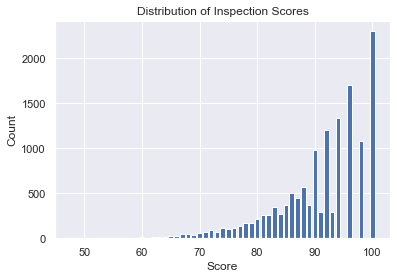

In [60]:
count = ins['score'].value_counts().to_frame()
score = count.index
counts = count['score']
plt.bar(score,counts)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Distribution of Inspection Scores")

### Question 7b

Describe the qualities of the distribution of the inspections scores based on your bar plot. Consider the mode(s), symmetry, tails, gaps, and anamolous values. Are there any unusual features of this distribution? What do your observations imply about the scores?

As we can see in this bar plot, the mode of all scores is 100. It is asymmetry and has a tail towards left. Some scores are not observed between 90 and 100. Scores around 65 is anamolous. One unusual feature is that most inspection scores are between 90 and 100 while the scores are concentrated on around 5 scores. Unlikely, there are relatively less scores range from 75 to 90 while roughly all integer scores are given. This observation implies that most of restaurants are good and got high score, some restaurants didn't reach the standards due to several reasons. Different standards have different measurements, if a restaurant didn't reach a number of standards, the score is low and more likely to be different to each other. For the restaurants that hardly loss scores, they may be more likely to get similar scores with only one or two weakness. 

### Question 7c

Let's figure out which restaurants had the worst scores ever (single lowest score). Let's start by creating a new dataframe called `ins_named`. It should be exactly the same as `ins`, except that it should have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address should be given as NaN.

*Hint*: Use the merge method to join the `ins` dataframe with the appropriate portion of the `bus` dataframe. See the official [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) on how to use `merge`.

*Note*: For quick reference, a pandas 'left' join keeps the keys from the left frame, so if ins is the left frame, all the keys from ins are kept and if a set of these keys don't have matches in the other frame, the columns from the other frame for these "unmatched" key rows contains NaNs.

<!--
BEGIN QUESTION
name: q7c1
points: 1
-->

In [66]:
ins_named = pd.merge(ins, bus[['business_id','name','address']], on='business_id', how='left')
ins_named.head()

,business_id,score,date,type,new_date,year,name,address
0,19,94,20160513,routine,2016-05-13,2016,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
1,19,94,20171211,routine,2017-12-11,2017,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
2,24,98,20171101,routine,2017-11-01,2017,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
3,24,98,20161005,routine,2016-10-05,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
4,24,96,20160311,routine,2016-03-11,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"


Using this data frame, identify the restaurant with the lowest inspection scores ever. Head to yelp.com and look up the reviews page for this restaurant. Copy and paste anything interesting you want to share.

<!--
BEGIN QUESTION
name: q7c2
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

The restaurant with the lowest inspection score ever is 'DA CAFE'. 'DA CAFE' got 48 score in 2016 for 9 violations most of which are uncleanness and inadequate food safety(https://www.yelp.com/inspections/d-and-a-cafe-san-francisco-5).

Just for fun you can also look up the restaurants with the best scores. You'll see that lots of them aren't restaurants at all!

---
## 8: Restaurant Ratings Over Time

Let's consider various scenarios involving restaurants with multiple ratings over time.

### Question 8a
Let's see which restaurant has had the most extreme improvement in its rating, aka scores. Let the "swing" of a restaurant be defined as the difference between its highest-ever and lowest-ever rating. **Only consider restaurants with at least 3 ratings, aka rated for at least 3 times (3 scores)!** Using whatever technique you want to use, assign `max_swing` to the name of restaurant that has the maximum swing.

*Note*: The "swing" is of a specific business. There might be some restaurants with multiple locations; each location has its own "swing".

In [68]:
selectedframe = ins_named.groupby(ins_named['business_id']).filter(lambda x: x['business_id'].count() >= 3)
maxdiff = selectedframe['score'].groupby(selectedframe['business_id']).apply(lambda x: max(x)-min(x)).max()
want = selectedframe['score'].groupby(selectedframe['business_id']).apply(lambda x: max(x)-min(x)).to_frame()
want[want['score'] == 39] # id = 2044
max_swing = ins_named[ins_named['business_id'] == 2044]['name'][1207]
max_swing

"JOANIE'S DINER INC."

### Question 8b

To get a sense of the number of times each restaurant has been inspected, create a multi-indexed dataframe called `inspections_by_id_and_year` where each row corresponds to data about a given business in a single year, and there is a single data column named `count` that represents the number of inspections for that business in that year. The first index in the MultiIndex should be on `business_id`, and the second should be on `year`.

An example row in this dataframe might look tell you that business_id is 573, year is 2017, and count is 4.

*Hint: Use groupby to group based on both the `business_id` and the `year`.*

*Hint: Use rename to change the name of the column to `count`.*

In [70]:
inspections_by_id_and_year = ins_named.groupby([ins_named['business_id'],ins_named['year']])['score'].count().to_frame().rename({'score':'count'}, axis = 1)
inspections_by_id_and_year.head()

count
business_id year       
19          2016      1
            2017      1
24          2016      2
            2017      1
31          2015      1

You should see that some businesses are inspected many times in a single year. Let's get a sense of the distribution of the counts of the number of inspections by calling `value_counts`. There are quite a lot of businesses with 2 inspections in the same year, so it seems like it might be interesting to see what we can learn from such businesses.

In [71]:
inspections_by_id_and_year['count'].value_counts()

1    9531
2    2175
3     111
4       2
Name: count, dtype: int64

### Question 8c

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? For simplicity, let's focus on only 2016 for this problem, using `ins2016` data frame that will be created for you below. 

First, make a dataframe called `scores_pairs_by_business` indexed by `business_id` (containing only businesses with exactly 2 inspections in 2016).  This dataframe contains the field `score_pair` consisting of the score pairs **ordered chronologically**  `[first_score, second_score]`. 

Plot these scores. That is, make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1. 

You may find the functions `sort_values`, `groupby`, `filter` and `agg` helpful, though not all necessary. 

The first few rows of the resulting table should look something like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>score_pair</th>
    </tr>
    <tr>
      <th>business_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>24</th>
      <td>[96, 98]</td>
    </tr>
    <tr>
      <th>45</th>
      <td>[78, 84]</td>
    </tr>
    <tr>
      <th>66</th>
      <td>[98, 100]</td>
    </tr>
    <tr>
      <th>67</th>
      <td>[87, 94]</td>
    </tr>
    <tr>
      <th>76</th>
      <td>[100, 98]</td>
    </tr>
  </tbody>
</table>

The scatter plot should look like this:

<img src="q8c2.png" width=500>

*Note: Each score pair must be a list type; numpy arrays will not pass the autograder.*

*Hint: Use the `filter` method from lecture 3 to create a new dataframe that only contains restaurants that received exactly 2 inspections.*

*Hint: Our answer is a single line of code that uses `sort_values`, `groupby`, `filter`, `groupby`, `agg`, and `rename` in that order. Your answer does not need to use these exact methods.*


In [73]:
ins2016 = ins[ins['year'] == 2016]
def combinetwo(x):
    return [x.iloc[0],x.iloc[1]]

myframe1 = ins2016.groupby(ins2016['business_id']).filter(lambda x: x['score'].count() == 2)
myframe2 = myframe1.groupby(myframe1['business_id']).apply(lambda x: x.sort_values('new_date'))
myframe3 = myframe2.groupby(myframe2['business_id'])['score'].agg(combinetwo).to_frame().rename({'score':'score_pair'},axis = 1)
scores_pairs_by_business = myframe3
ins2016 = ins[ins['year'] == 2016]

Now, create your scatter plot in the cell below. It does not need to look exactly the same (e.g., no grid) as the above sample, but make sure that all labels, axes and data itself are correct.

*Hint*: Use `plt.plot()` for the reference line, if you are using matplotlib.

*Hint*: Use `facecolors='none'` to make circle markers.

*Hint*: Use `zip()` function to unzip scores in the list.
<!--
BEGIN QUESTION
name: q8c2
points: 3
manual: True
-->
<!-- EXPORT TO PDF -->

(55, 100)

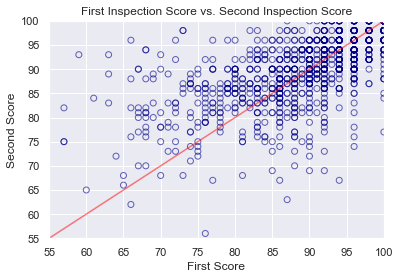

In [74]:
xs = np.arange(55, 101)
ys = xs
plt.plot(xs,ys,color = 'red',alpha = 0.5)

plt.scatter(*zip(*scores_pairs_by_business['score_pair']),
            edgecolor='darkblue',
            facecolors='none',
            alpha = 0.6)
plt.xlabel('First Score')
plt.ylabel('Second Score')
plt.title('First Inspection Score vs. Second Inspection Score')

plt.ylim((55,100))
plt.xlim((55,100))

### Question 8d

Another way to compare the scores from the two inspections is to examine the difference in scores. Subtract the first score from the second in `scores_pairs_by_business`. Make a histogram of these differences in the scores. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.

The histogram should look like this:

<img src="q8d.png" width=500>

*Hint*: Use `second_score` and `first_score` created in the scatter plot code above.

*Hint*: Convert the scores into numpy arrays to make them easier to deal with.

*Hint*: Use `plt.hist()` Try changing the number of bins when you call `plt.hist()`.

Text(0, 0.5, 'Count')

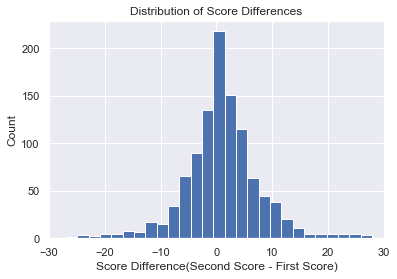

In [77]:
def score1(x):
    return x.iloc[0]
def score2(x):
    return x.iloc[1]

newframe = myframe2['score'].groupby(myframe2['business_id']).agg([score1,score2])
newframe1 = newframe.assign(diff = lambda x: x.score2 - x.score1).sort_values('diff')
mydiff = newframe1['diff'].to_frame()

mydiff.hist(bins = 30)
plt.xlim((-30,30))
plt.title('Distribution of Score Differences')
plt.xlabel('Score Difference(Second Score - First Score)')
plt.ylabel('Count')

### Question 8e

If a restaurant's score improves from the first to the second inspection, what do you expect to see in the scatter plot that you made in question 8c? What do you see?

If a restaurant's score improves from the first to the second inspection, how would this be reflected in the histogram of the difference in the scores that you made in question 8d? What do you see?

If a restaurant's score improves from the first to the second inspection, the point would be in the upper triangle of the scatter plot. The score difference is positive so it would be in the right part of histogram.



## Summary of the Inspections Data

What we have learned about the inspections data? What might be some next steps in our investigation? 

* We found that the records are at the inspection level and that we have inspections for multiple years.   
* We also found that many restaurants have more than one inspection a year. 
* By joining the business and inspection data, we identified the name of the restaurant with the worst rating and optionally the names of the restaurants with the best rating.
* We identified the restaurant that had the largest swing in rating over time.
* We also examined the relationship between the scores when a restaurant has multiple inspections in a year. Our findings were a bit counterintuitive and may warrant further investigation. 


## Congratulations!

You are finished with Project 1. 